A VAR model is a generalisation of the AR framework in that it retains the linear combination approach but allows us to model multiple (or multi-variate) timeseries at once.

Formally, let $Y_t$ be a vector, where:

$$Y_T = \nu + A_1Y_{T_1} + A_2Y_{T-p}+e_t$$

where the $A$s are coefficient matrices to be combined with the past values of each individual timeseries. 
E.g. economic example:

$$\begin{bmatrix}
gdp\\ 
inv\\ 
con
\end{bmatrix}_T = \nu + 
A_1 \begin{bmatrix}
gdp\\ 
inv\\ 
con
\end{bmatrix}_{T-1}+
A_2 \begin{bmatrix}
gdp\\ 
inv\\ 
con
\end{bmatrix}_{T-2}+
\dots + 
A_p \begin{bmatrix}
gdp\\ 
inv\\ 
con
\end{bmatrix}_{T-p} +
e_t$$

The thing we are trying to estimate when we fit a VAR model is the $A$ matrices that determine the nature of the lienar combination that best fits our timeseries data.

**Such timeseries models can have AR or a MA representation and the details matter for some of the implications of a VAR model fit**

The matrix notation is convenient to suggest the broad patterns of the model, but it is useful to see the algebra is a simple case. Consider the case of Ireland’s GDP and consumption described as:

$$gdp_t = \beta_{gdp1}\cdot gdp_{t-1} + \beta_{gdp2}\cdot gdp_{t-2} + \beta_{cons1}\cdot const_{t-1}+\beta_{cons2}\cdot const_{t-2} + \epsilon_{gdp}$$

In this way we can see that if we can estimate the 
 terms we have an estimate for the bi-directional effects of each variable on the other. This is a useful feature of the modelling.

## Data Simulation:

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

import statsmodels.api as sm

# from pymc.sampling_jax import sample_blackjax_nuts

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [3]:
def simulate_var(
    intercepts, coefs_yy, coefs_xy, coefs_xx, coefs_yx, noises=(1, 1), *, warmup=100, steps=200
):
    draws_y = np.zeros(warmup + steps)
    draws_x = np.zeros(warmup + steps)
    draws_y[:2] = intercepts[0]
    draws_x[:2] = intercepts[1]
    for step in range(2, warmup + steps):
        draws_y[step] = (
            intercepts[0]
            + coefs_yy[0] * draws_y[step - 1]
            + coefs_yy[1] * draws_y[step - 2]
            + coefs_xy[0] * draws_x[step - 1]
            + coefs_xy[1] * draws_x[step - 2]
            + rng.normal(0, noises[0])
        )
        draws_x[step] = (
            intercepts[1]
            + coefs_xx[0] * draws_x[step - 1]
            + coefs_xx[1] * draws_x[step - 2]
            + coefs_yx[0] * draws_y[step - 1]
            + coefs_yx[1] * draws_y[step - 2]
            + rng.normal(0, noises[1])
        )
    return draws_y[warmup:], draws_x[warmup:]

Simulate data from the VAR(2) model - two lagged terms:

In [4]:
var_y, var_x = simulate_var(
    intercepts=(18, 8),
    coefs_yy=(-0.8, 0),
    coefs_xy=(0.9, 0),
    coefs_xx=(1.3, -0.7),
    coefs_yx=(-0.1, 0.3),
)

df = pd.DataFrame({"x": var_x, "y": var_y})
df.head()

x          y
0  34.606613  30.117581
1  34.773803  23.996700
2  35.455237  29.738941
3  33.886706  27.193417
4  31.837465  26.704728

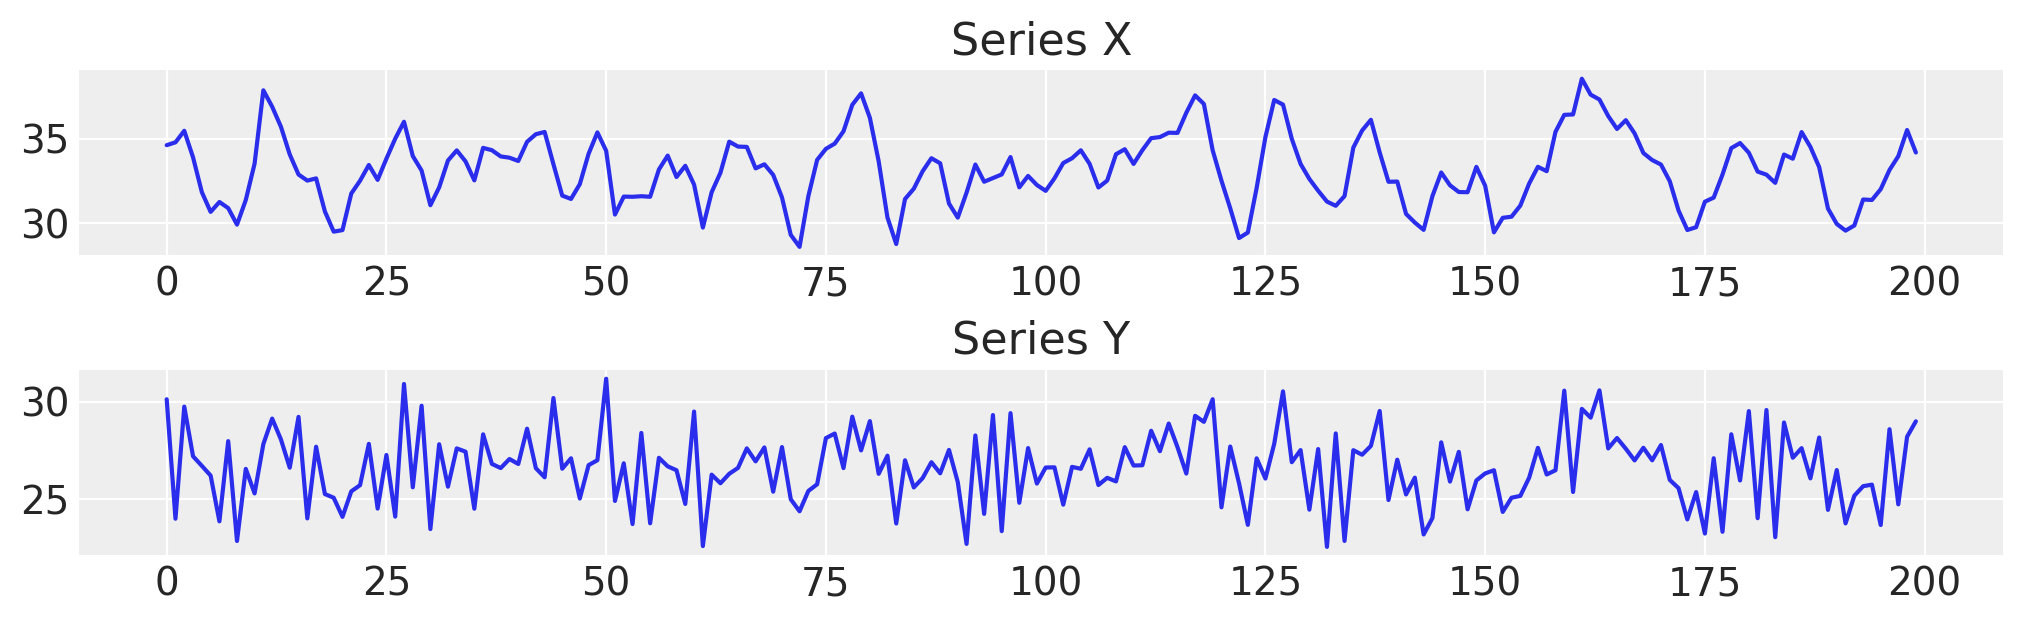

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10, 3))
axs[0].plot(df["x"], label="x")
axs[0].set_title("Series X")
axs[1].plot(df["y"], label="y")
axs[1].set_title("Series Y");

Helper functions are used to abstract some of the model definitions:

In [9]:
### Define a helper function that will construct our autoregressive step for the marginal contribution of each lagged
### term in each of the respective time series equations
### Notes: this is just matrix A above.
def calc_ar_step(lag_coefs, n_eqs, n_lags, df):
    ars = []
    for j in range(n_eqs):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[j, i] * df.values[n_lags - (i + 1) : -(i + 1)], axis=-1)
                for i in range(n_lags)
            ],
            axis=0,
        )
        ars.append(ar)
    beta = pm.math.stack(ars, axis=-1)

    return beta

In [1]:
### Make the model in such a way that it can handle different specifications of the likelihood term
### and can be run for simple prior predictive checks. This latter functionality is important for debugging of
### shape handling issues. Building a VAR model involves quite a few moving parts and it is handy to
### inspect the shape implied in the prior predictive checks.
def make_model(n_lags, n_eqs, df, priors, mv_norm=True, prior_checks=True):
    coords = {
        "lags": np.arange(n_lags) + 1,
        "equations": df.columns.tolist(),
        "cross_vars": df.columns.tolist(),
        "time": [x for x in df.index[n_lags:]],
    }

    with pm.Model(coords=coords) as model:
        lag_coefs = pm.Normal(
            "lag_coefs",
            mu=priors["lag_coefs"]["mu"],
            sigma=priors["lag_coefs"]["sigma"],
            dims=["equations", "lags", "cross_vars"],
        )
        alpha = pm.Normal(
            "alpha", mu=priors["alpha"]["mu"], sigma=priors["alpha"]["sigma"], dims=("equations",)
        )
        data_obs = pm.Data("data_obs", df.values[n_lags:], dims=["time", "equations"], mutable=True)

        betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df)
        betaX = pm.Deterministic(
            "betaX",
            betaX,
            dims=[
                "time",
            ],
        )
        mean = alpha + betaX

        if mv_norm:
            n = df.shape[1]
            ## Under the hood the LKJ prior will retain the correlation matrix too.
            noise_chol, _, _ = pm.LKJCholeskyCov(
                "noise_chol",
                eta=priors["noise_chol"]["eta"],
                n=n,
                sd_dist=pm.HalfNormal.dist(sigma=priors["noise_chol"]["sigma"]),
            )
            obs = pm.MvNormal(
                "obs", mu=mean, chol=noise_chol, observed=data_obs, dims=["time", "equations"]
            )
        else:
            ## This is an alternative likelihood that can recover sensible estimates of the coefficients
            ## But lacks the multivariate correlation between the timeseries.
            sigma = pm.HalfNormal("noise", sigma=priors["noise"]["sigma"], dims=["equations"])
            obs = pm.Normal(
                "obs", mu=mean, sigma=sigma, observed=data_obs, dims=["time", "equations"]
            )

        if prior_checks:
            idata = pm.sample_prior_predictive()
            return model, idata
        else:
            idata = pm.sample_prior_predictive()
            idata.extend(pm.sample(draws=2000, random_seed=130))
            pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)
    return model, idata

The model has a deterministic component in the auto-regressive calculation which is required at each timestep, but the key point here is that we model the likelihood of the VAR as a multivariate normal distribution with a particular covariance relationship. The estimation of these covariance relationship gives the main insight in the manner in which our component timeseries relate to one another.

Sampling: [alpha, lag_coefs, noise_chol, obs]


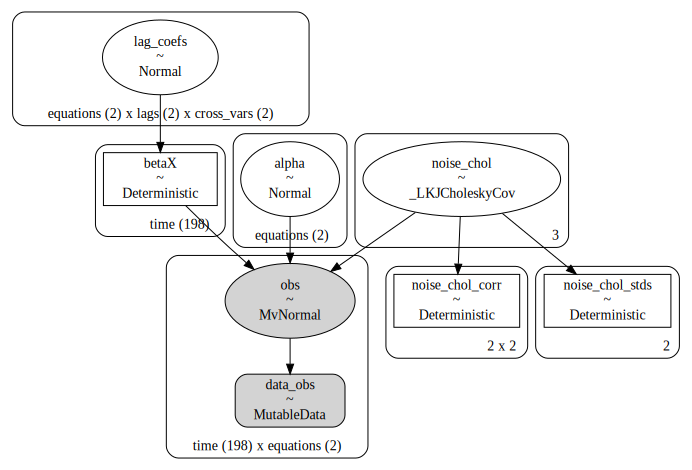

In [11]:
n_lags = 2
n_eqs = 2
priors = {
    "lag_coefs": {"mu": 0.3, "sigma": 1},
    "alpha": {"mu": 15, "sigma": 5},
    "noise_chol": {"eta": 1, "sigma": 1},
    "noise": {"sigma": 1},
}

model, idata = make_model(n_lags, n_eqs, df, priors)
pm.model_to_graphviz(model)

Another VAR with 3 lags and 2 equations.

Sampling: [alpha, lag_coefs, noise_chol, obs]


  lag_coefs: shape=(2, 3, 2)
      alpha: shape=(2,)
noise_chol_cholesky-cov-packed__: shape=(3,)
 noise_chol: shape=(3,)


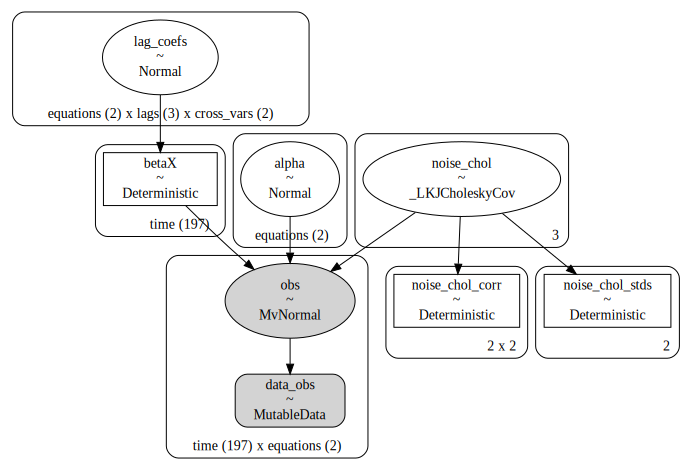

In [12]:
n_lags = 3
n_eqs = 2
model, idata = make_model(n_lags, n_eqs, df, priors)
for rv, shape in model.eval_rv_shapes().items():
    print(f"{rv:>11}: shape={shape}")
pm.model_to_graphviz(model)

We can inspect the correlation matrix between our timeseries which is implied by the prior specification, to see that we have allowed a flat uniform prior over their correlation.

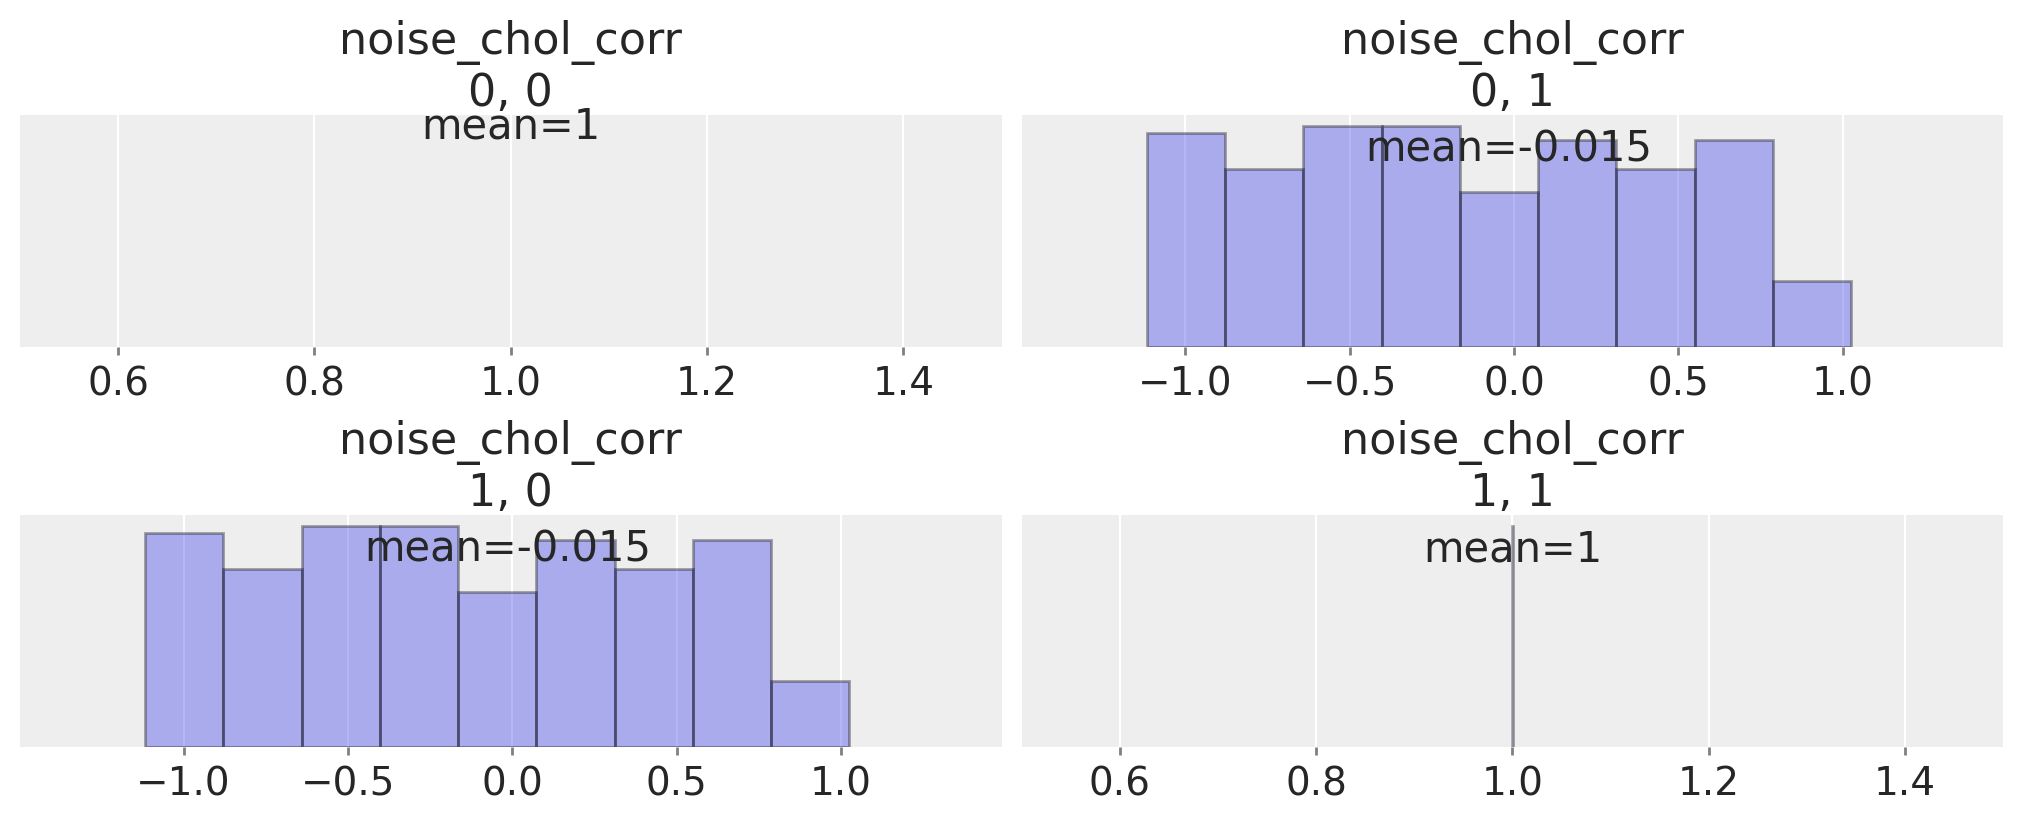

In [13]:
ax = az.plot_posterior(
    idata,
    var_names="noise_chol_corr",
    hdi_prob="hide",
    group="prior",
    point_estimate="mean",
    grid=(2, 2),
    kind="hist",
    ec="black",
    figsize=(10, 4),
)

Now we will fit the VAR with 2 lags and 2 equations

In [14]:
n_lags = 2
n_eqs = 2
model, idata_fake_data = make_model(n_lags, n_eqs, df, priors, prior_checks=False)

Sampling: [alpha, lag_coefs, noise_chol, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lag_coefs, alpha, noise_chol]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1649 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [obs]


In [15]:
az.summary(idata_fake_data, var_names=["alpha", "lag_coefs", "noise_chol_corr"])

/opt/conda/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha[x]                8.588  1.772   5.083   11.740      0.039    0.027   
alpha[y]               17.181  1.809  13.795   20.522      0.042    0.030   
lag_coefs[x, 1, x]      1.333  0.062   1.222    1.457      0.001    0.001   
lag_coefs[x, 1, y]     -0.119  0.069  -0.244    0.016      0.002    0.001   
lag_coefs[x, 2, x]     -0.713  0.098  -0.894   -0.534      0.002    0.002   
lag_coefs[x, 2, y]      0.269  0.075   0.140    0.416      0.002    0.001   
lag_coefs[y, 1, x]      0.834  0.062   0.723    0.958      0.001    0.001   
lag_coefs[y, 1, y]     -0.803  0.071  -0.932   -0.663      0.002    0.001   
lag_coefs[y, 2, x]      0.101  0.100  -0.086    0.287      0.002    0.002   
lag_coefs[y, 2, y]     -0.008  0.075  -0.136    0.145      0.002    0.001   
noise_chol_corr[0, 0]   1.000  0.000   1.000    1.000      0.000    0.000   
noise_chol_corr[0, 1]   0.019  0.071  -0.106    0.160      0.001    0.001   
noise_chol_corr[1, 0]   0.019  0.071  -0.106    0.160      0.001    0.001   
noise_chol_corr[1, 1]   1.000  0.000   1.000    1.000      0.000    0.000   

                       ess_bulk  ess_tail  r_hat  
alpha[x]                 2097.0    2514.0   1.00  
alpha[y]                 1837.0    2503.0   1.00  
lag_coefs[x, 1, x]       2621.0    2667.0   1.00  
lag_coefs[x, 1, y]       1989.0    2371.0   1.00  
lag_coefs[x, 2, x]       1849.0    2112.0   1.00  
lag_coefs[x, 2, y]       1765.0    2311.0   1.00  
lag_coefs[y, 1, x]       2440.0    2140.0   1.00  
lag_coefs[y, 1, y]       1996.0    2176.0   1.00  
lag_coefs[y, 2, x]       1764.0    1956.0   1.01  
lag_coefs[y, 2, y]       1746.0    2019.0   1.00  
noise_chol_corr[0, 0]    4000.0    4000.0    NaN  
noise_chol_corr[0, 1]    3676.0    2735.0   1.00  
noise_chol_corr[1, 0]    3676.0    2735.0   1.00  
noise_chol_corr[1, 1]    4093.0    4000.0   1.00

In [16]:
az.plot_posterior(idata_fake_data, var_names=["alpha"], ref_val=[8, 18]);

Next we’ll plot the posterior predictive distribution to check that the fitted model can capture the patterns in the observed data. This is the primary test of goodness of fit.

In [17]:
def shade_background(ppc, ax, idx, palette="cividis"):
    palette = palette
    cmap = plt.get_cmap(palette)
    percs = np.linspace(51, 99, 100)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            ppc[:, idx, :],
            p,
            axis=1,
        )
        lower = np.percentile(
            ppc[:, idx, :],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        ax[idx].fill_between(
            x=np.arange(ppc.shape[0]),
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )


def plot_ppc(idata, df, group="posterior_predictive"):
    fig, axs = plt.subplots(2, 1, figsize=(25, 15))
    df = pd.DataFrame(idata_fake_data["observed_data"]["obs"].data, columns=["x", "y"])
    axs = axs.flatten()
    ppc = az.extract(idata, group=group, num_samples=100)["obs"]
    # Minus the lagged terms and the constant
    shade_background(ppc, axs, 0, "inferno")
    axs[0].plot(np.arange(ppc.shape[0]), ppc[:, 0, :].mean(axis=1), color="cyan", label="Mean")
    axs[0].plot(df["x"], "o", mfc="black", mec="white", mew=1, markersize=7, label="Observed")
    axs[0].set_title("VAR Series 1")
    axs[0].legend()
    shade_background(ppc, axs, 1, "inferno")
    axs[1].plot(df["y"], "o", mfc="black", mec="white", mew=1, markersize=7, label="Observed")
    axs[1].plot(np.arange(ppc.shape[0]), ppc[:, 1, :].mean(axis=1), color="cyan", label="Mean")
    axs[1].set_title("VAR Series 2")
    axs[1].legend()


plot_ppc(idata_fake_data, df)

We can check the learned posterior distribution for the correlation parameter.

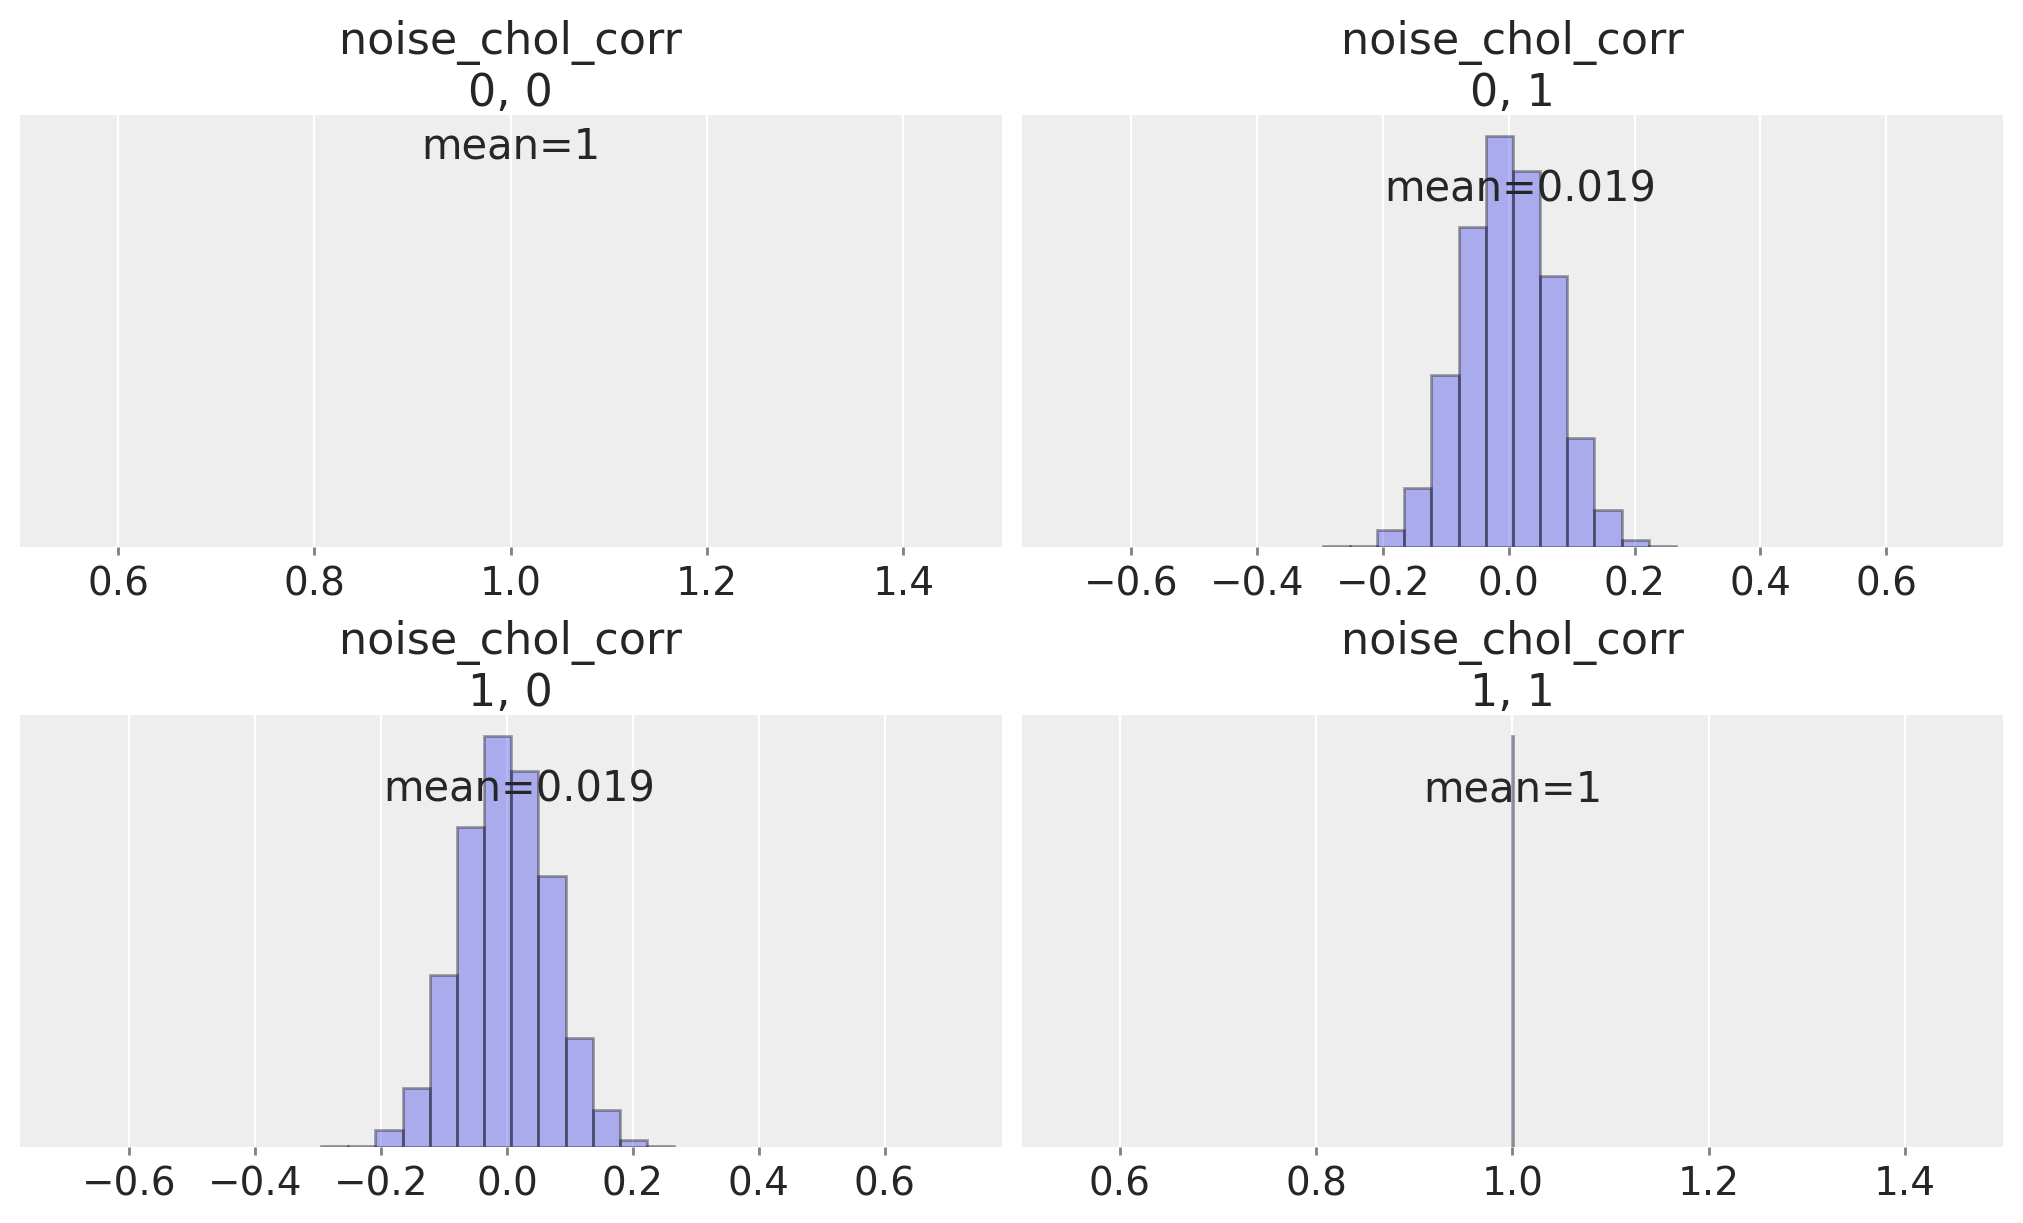

In [18]:
ax = az.plot_posterior(
    idata_fake_data,
    var_names="noise_chol_corr",
    hdi_prob="hide",
    point_estimate="mean",
    grid=(2, 2),
    kind="hist",
    ec="black",
    figsize=(10, 6),
)